# Titanic 乘客幸存预测

## 1 题解

这是kaggle入门题，根据`data/train.csv`数据集构建模型，在`data/test.csv`上预测幸存与否（0=罹难，1=幸存）。这是两分类预测，可使用常用的机器学习分类器解决，最后用accuracy/precision/recall/F1/auc/roc等指标来评价。

## 2 准备工作

### 2.1 加载需要的包

除了必备基建`pandas`，可视化利器`matplotlib`、`seaborn`（或交互图工具`plotly`、`altair`），还需要从`scikit-learn`加载一系列必要的模块。

> `xgboost`尚未集成进`scikit-learn`，需要单独安装引入。

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
import plotly
import time
from IPython.display import HTML, display
from scipy.stats import chi2_contingency, f_oneway
import statsmodels.api as sm
# sklearn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, Normalizer, \
    OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, auc, roc_curve, confusion_matrix, \
    f1_score, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
# algorithms
from sklearn.linear_model import LinearRegression, LogisticRegression, \
    RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, \
    QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, \
    GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier

In [2]:
# show all the output instead of the last one 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 200)
%matplotlib inline

### 2.2 加载数据

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## 3. 探索性分析 (EDA)

描述数据结构，并开展初步的关联分析。

### 3.1 数据结构

数据字典定义可参考kaggle和[README](./README.md)。但仍有必要快速查看一下数据的结构（规模、分布、水平、缺失等情况）。

In [4]:
print('train的数据集大小为%s\ntest的数据集大小为%s' % 
      (str(train.shape), str(test.shape)))

train的数据集大小为(891, 12)
test的数据集大小为(418, 11)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


可以看到，Age和Cabin有大量缺失。

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 3.2 单变量描述

对于连续性变量，可以用`describe()`方法来描述。

In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
def describe_var(var:str, df:pd.DataFrame=train):
    """Descriptive analysis of single variable
    Continuous variable: histgram + stat description
    Categorical variable: bar plot + contingency table
    """
    if df[var].dtype in ('float',):
        sns.distplot(df[var])
        plt.show()
        return pd.DataFrame(df[var].describe()).T
    elif df[var].dtype in ('int', 'O', 'category'):
        sns.countplot(df[var])
        plt.show()
        return pd.DataFrame(df[var].value_counts(dropna=False))

`PassengerId`, `Name`, `Ticket`分布上没有聚集趋势。剩下的变量看一下分布。

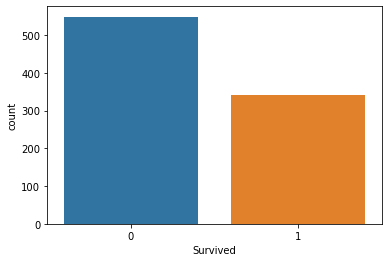

,Survived
0,549
1,342


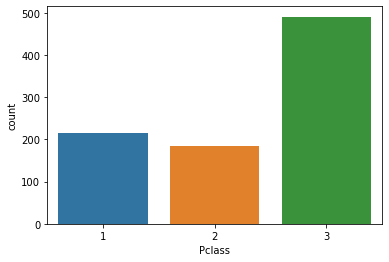

,Pclass
3,491
1,216
2,184


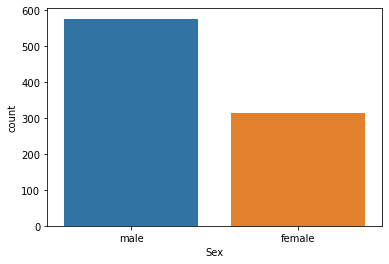

,Sex
male,577
female,314


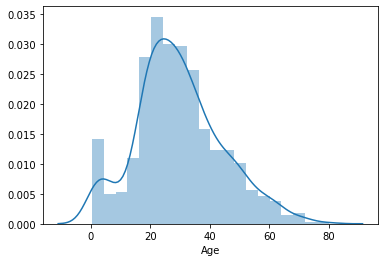

,count,mean,std,min,25%,50%,75%,max
Age,714.0,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0


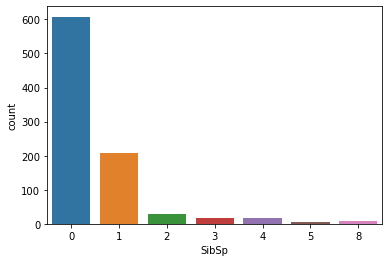

,SibSp
0,608
1,209
2,28
4,18
3,16
8,7
5,5


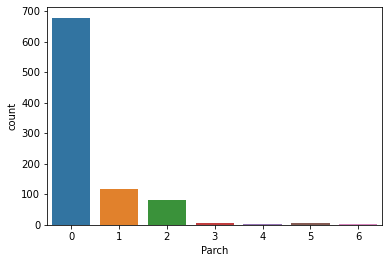

,Parch
0,678
1,118
2,80
5,5
3,5
4,4
6,1


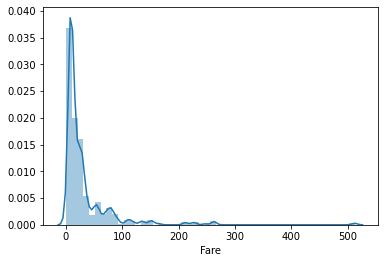

,count,mean,std,min,25%,50%,75%,max
Fare,891.0,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


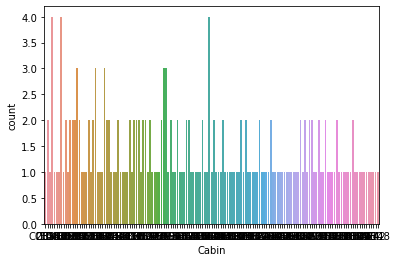

,Cabin
NaN,687
C23 C25 C27,4
G6,4
B96 B98,4
E101,3
D,3
C22 C26,3
F33,3
F2,3
B57 B59 B63 B66,2


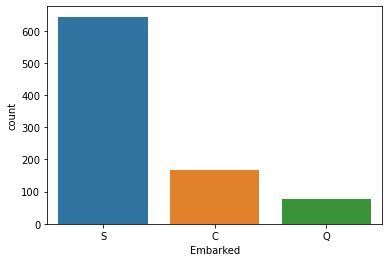

,Embarked
S,644
C,168
Q,77
NaN,2


In [9]:
vars = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']
for i in range(len(vars)):
    display(HTML('<h4>3.2.%d %s分布</h4>' % (i+1, vars[i])))
    if (train[vars[i]].dtype=='int') and (train[vars[i]].nunique()<10):
        train[vars[i]] = train[vars[i]].astype('category')
    describe_var(vars[i])

### 3.3 单因素相关性

/Users/madlogos/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


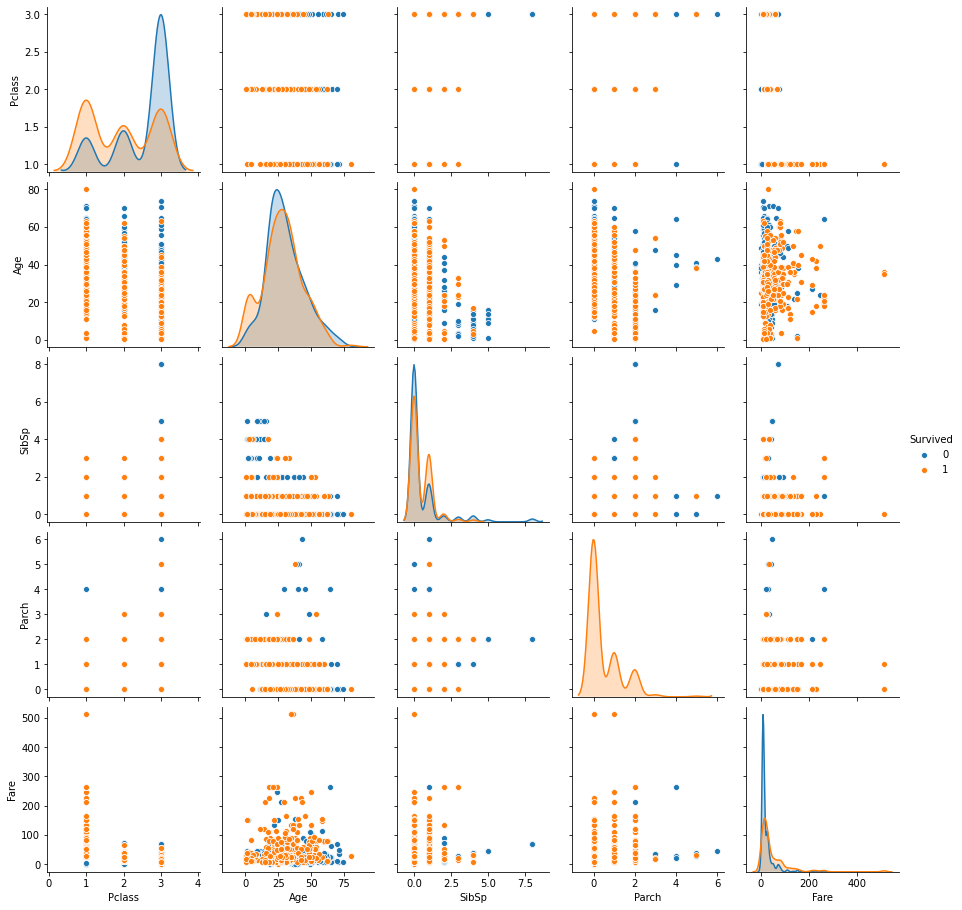

In [10]:
sns.pairplot(train[vars], hue='Survived');

构造一个`univar_test()`函数，遍历变量，与Survived做单因素检验。

In [11]:
def univar_test(var:str, df:pd.DataFrame=train):
    """Test the correlation of var with Survived
    """
    if df[var].dtype in ('float',):
        mtd = 'anova'
        o = f_oneway(df[var][df['Survived']==0].dropna(),
                     df[var][df['Survived']==1].dropna())
    elif df[var].dtype in ('int', 'O', 'category'):
        mtd = 'chi2'
        o = chi2_contingency(
            pd.crosstab(train[var], train['Survived']).to_numpy())
    return {'var': var, 'method': mtd, 'stat': o[0], 'p-value': o[1]}

In [12]:
uni_test = []
for var in vars:
    if not var in ['Survived', 'Cabin']:
        uni_test.append(univar_test(var))
pd.DataFrame(uni_test)

,var,method,stat,p-value
0,Pclass,chi2,102.888989,4.549252e-23
1,Sex,chi2,260.717020,1.197357e-58
2,Age,anova,4.271195,3.912465e-02
3,SibSp,chi2,37.271793,1.558581e-06
4,Parch,chi2,27.925784,9.703526e-05
5,Fare,anova,63.030764,6.120189e-15
6,Embarked,chi2,26.489150,1.769922e-06


仅看单因素分析的结果，基本上所有特征都与生存结局有关联。

部分变量含义不明确，单独探查一下。

#### (1) `SibSp`和`Parch`

In [13]:
pd.crosstab(train['SibSp'], train['Parch'])

Parch,0,1,2,3,4,5,6
SibSp,,,,,,,
0,537,38,29,1,1,2,0
1,123,57,19,3,3,3,1
2,16,7,4,1,0,0,0
3,2,7,7,0,0,0,0
4,0,9,9,0,0,0,0
5,0,0,5,0,0,0,0
8,0,0,7,0,0,0,0


In [14]:
print(
    'Stat: %.6f, p-value: %.6f' % 
    chi2_contingency(pd.crosstab(train['SibSp'], train['Parch']).to_numpy())[:2])

Stat: 341.681987, p-value: 0.000000


`SibSp`和`Parch`有很强的正自相关性，对模型性能可能带来损害。可以考虑合并。

#### (2) `Fare`和`Age`、`Pclass`、`Embarked`

基于常识，费用和年龄、舱位级别、登船地点可能存在自相关。但从上面的pairplot来看，`Fare`和`Age`、`Pclass`的关联不大。

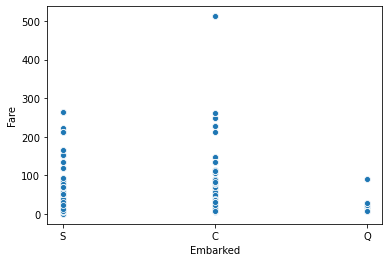

In [15]:
sns.scatterplot(train['Embarked'], train['Fare']);

由上图来看，`Fare`和`Embarked`的关联也不大。

## 4. 特征工程

需要填补缺失值，抽取/构造特征，用于建模。特征工程的步骤写进pipeline，以便在测试集上复用。

### 4.1 缺失填补

缺失值填补有很多方法，简单均数、分组均数、众数或监督学习都有应用。

#### (1) 登船地

登船地有少数缺失。假定舱位和船票保留了登船地的某些信息，可以分组求出众数来填补。

In [16]:
pd.crosstab([train.Cabin.fillna('U').str.slice(0,1),
             train.Ticket.str.slice(0, 2)], train.Embarked)

Embarked       C   Q    S
Cabin Ticket             
A     11       2   0    5
      13       2   0    0
      17       1   0    0
      27       0   0    1
      33       0   0    1
      PC       2   0    1
B     11       6   0   12
      12       0   0    2
      13       3   0    0
      17       0   0    2
      24       0   0    3
      69       0   0    1
      F.       0   0    1
      PC      13   0    0
      WE       0   0    2
C     11       6   0   17
      17       5   0    0
      19       0   2   11
      36       0   0    3
      PC      10   0    5
D     11       2   0    6
      13       0   0    3
      16       0   0    1
      17       0   0    3
      24       0   0    1
      28       0   0    1
      35       3   0    2
      36       2   0    2
      PC       4   0    1
      SC       2   0    0
E     11       1   0    9
      13       0   0    3
      16       2   0    0
      17       0   0    1
      19       0   0    1
      22       0   1    0
      27       0   0    1
      34       0   0    1
      39       0   0    2
      57       0   0    1
      PC       2   0    4
      S.       0   0    1
      SO       0   0    1
      W.       0   0    1
F     23       0   0    5
      24       0   0    1
      26       1   0    0
      34       0   0    3
      38       0   1    0
      C.       0   0    2
G     34       0   0    2
      PP       0   0    2
T     11       0   0    1
U     11       3   0   16
      12       0   1    1
      14       0   3    1
      16       0   0    7
      17       1   0    0
      19       0   0    2
      20       0   0    1
      21       0   1    3
      22       0   0    8
      23       2   1   28
      24       0   0   24
      25       0   0   14
      26      56   0    3
      27       1   0    1
      28       0   0   11
      29       0   0   14
      31       0   0   37
      32       0   0    3
      33       0  15    0
      34       8   0  118
      35       0   2   20
      36       0  24   15
      37       0  15   10
      38       0   8    1
      39       0   1    2
      41       0   0    9
      45       0   0    1
      54       0   0    2
      65       0   0    4
      69       0   0    1
      72       0   0    1
      75       0   0    8
      84       0   0    2
      92       0   1    0
      A.       0   0    4
      A/       0   1   23
      A4       0   0    1
      C        0   0    5
      C.       0   0   26
      CA       0   0   14
      F.       0   0    5
      Fa       0   0    1
      LI       0   0    4
      P/       2   0    0
      PC      15   0    3
      PP       0   0    1
      S.       2   0   11
      SC       9   0    3
      SO       0   0   17
      ST       0   0   18
      SW       0   0    1
      W.       0   0    9
      W/       0   0    1

由上表，多数情况下组合是有良好区分度的。构造一个填补函数，利用分箱众数填补`Embarked`，试运行一下，填补完整。

In [17]:
def imp_embark(df:pd.DataFrame=train, inplace:bool=False) -> pd.DataFrame:
    o = df if inplace else df.copy()
    
    a = df[['Embarked', 'Ticket', 'Cabin']].copy()
    a['Cabin'] = a['Cabin'].fillna('U').str.slice(0, 1)
    a['Ticket'] = a['Ticket'].fillna('NA').str.slice(0, 2)
    a['idx'] = list(zip(a['Cabin'], a['Ticket']))
    
    a_sub = a.dropna(subset=['Embarked'])
    dct = pd.crosstab([a_sub['Cabin'], a_sub['Ticket']], a_sub['Embarked'])
    dct['mode'] = dct.idxmax(axis=1, skipna=True)
    dct = dct['mode'].to_dict()

    a['emb'] = a['idx'].map(dct)
    a.loc[a['Embarked'].isna(), 'Embarked'] = a.loc[a['Embarked'].isna(), 'emb']
    o['Embarked'] = a.reset_index()['Embarked']
    if not inplace:
        return o

a = imp_embark(train)
a[a['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


#### (2) 年龄

看一下Age信息完备的数据中，哪些特征与Age关联更高。

姓名Name中有头衔信息，可以考虑抽取出来表征乘客的社会地位。它们基本都符合'^[^,]+, [a-z]*([A-Z][a-z]+)..+$'的特征。这属于特征抽取的范畴，但考虑头衔可以用于年龄填补，先在这里执行。

In [18]:
pd.DataFrame(
    train['Name']
    .str.extract(r'^[^,]+, [a-z]* *([A-Z][a-z]+)\..+$')[0]
    .value_counts(dropna=False))

,0
Mr,517
Miss,182
Mrs,125
Master,40
Dr,7
Rev,6
Col,2
Mlle,2
Major,2
Lady,1


构造字典，将title归并到'Mr', 'Mrs', 'Miss', 'Master', 'Noble' 5个水平。

In [73]:
title_dict = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Dr': 'Master',
    'Rev': 'Master',
    'Mlle': 'Miss',
    'Major': 'Master',
    'Col': 'Master',
    'Ms': 'Mrs',
    'Don': 'Noble',
    'Dona': 'Noble',
    'Lady': 'Noble',
    'Jonkheer': 'Noble',
    'Countess': 'Noble',
    'Capt': 'Master',
    'Mme': 'Mrs',
    'Sir': 'Noble'}
def enc_title(df:pd.DataFrame=train, title_dict:dict=title_dict, 
              inplace:bool=False) -> pd.DataFrame:
    o = df if inplace else df.copy()
    o['Title'] = o['Name'].str.extract(r'^[^,]+, [a-z]* *([A-Z][a-z]+)\..+$')
    o['Title'] = o['Title'].map(title_dict).fillna('NA')
    if not inplace:
        return o

enc_title(train)[['Name', 'Title']].head()

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


In [23]:
a = enc_title(imp_embark(train))
b = pd.get_dummies(a[['Pclass', 'Title', 'Sex', 'Embarked']], drop_first=True)
a = pd.merge(a[['Age', 'SibSp', 'Parch']], b, left_index=True, right_index=True)
a.head()

,Age,SibSp,Parch,Pclass_2,Pclass_3,Title_Miss,Title_Mr,Title_Mrs,Title_Noble,Sex_male,Embarked_Q,Embarked_S
0,22.0,1,0,0,1,0,1,0,0,1,0,1
1,38.0,1,0,0,0,0,0,1,0,0,0,0
2,26.0,0,0,0,1,1,0,0,0,0,0,1
3,35.0,1,0,0,0,0,0,1,0,0,0,1
4,35.0,0,0,0,1,0,1,0,0,1,0,1


In [24]:
# run the linear regression model
b = a.dropna()
X = b.drop('Age', axis=1).astype(float)
reg = sm.OLS(b['Age'], X).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    Age   R-squared (uncentered):                   0.873
Model:                            OLS   Adj. R-squared (uncentered):              0.871
Method:                 Least Squares   F-statistic:                              438.0
Date:                Sun, 28 Jun 2020   Prob (F-statistic):                   7.50e-306
Time:                        00:09:14   Log-Likelihood:                         -2775.1
No. Observations:                 714   AIC:                                      5572.
Df Residuals:                     703   BIC:                                      5622.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
SibSp          -2.9661      0.548     -5.417      0.000      -4.041      -1.891
Parch          -1.0169      0.592     -1.718      0.086      -2.179       0.145
Pclass_2       -9.7877      1.324     -7.393      0.000     -12.387      -7.188
Pclass_3      -13.9560      1.160    -12.035      0.000     -16.233     -11.679
Title_Miss     29.6758      1.420     20.894      0.000      26.887      32.464
Title_Mr       11.7680      1.911      6.159      0.000       8.017      15.519
Title_Mrs      43.6315      1.609     27.116      0.000      40.472      46.791
Title_Noble    24.2587      5.441      4.459      0.000      13.577      34.940
Sex_male       28.4340      2.151     13.221      0.000      24.211      32.657
Embarked_Q      9.2089      2.566      3.589      0.000       4.171      14.247
Embarked_S      3.6684      1.223      2.999      0.003       1.267       6.070
==============================================================================
Omnibus:                       64.304   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.368
Skew:                           0.748   Prob(JB):                     2.14e-18
Kurtosis:                       3.706   Cond. No.                         19.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R^2为0.87，可以接受。构造一个填补函数，用上面的线性模型对缺失的`Age`进行填补。

In [25]:
def imp_age(df:pd.DataFrame=train, inplace:bool=False) -> pd.DataFrame:
    # construct the data set
    assert 'Title' in df.columns, \
        'Title is not found. Run enc_title() first.'
    assert df['Embarked'].notna().all(), \
        'There are NAs in Embarked. Run imp_embark() first.'
    a = df.copy()
    b = pd.get_dummies(a[['Pclass', 'Title', 'Sex', 'Embarked']], drop_first=True)
    a = pd.merge(a[['Age', 'SibSp', 'Parch']], b, left_index=True, right_index=True)
    # split dataset
    train = a[a['Age'].notna()]
    test = a[a['Age'].isna()]
    # model
    X_train = train.drop('Age', axis=1).astype(float)
    y_train = train['Age']
    mdl = sm.OLS(y_train, X_train).fit()
    # predict
    X_test = test.drop('Age', axis=1).astype(float)
    y_pred = mdl.predict(X_test)
    # out
    o = df if inplace else df.copy()
    o.loc[o['Age'].isna(), 'Age'] = y_pred
    if not inplace:
        return o
    
a = imp_age(imp_embark(enc_title(train)))
a[a['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title


#### (3) 费用

test中有Fare缺失。预计费用和年龄、舱等、登船地等因素有关。在train数据集中探查一下。

In [83]:
a = imp_embark(train)
b = pd.get_dummies(a[['Pclass', 'Embarked']], drop_first=True)
a = pd.merge(a[['Age', 'Fare']], b, left_index=True, right_index=True)
a.head()

,Age,Fare,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,22.0,7.2500,0,1,0,1
1,38.0,71.2833,0,0,0,0
2,26.0,7.9250,0,1,0,1
3,35.0,53.1000,0,0,0,1
4,35.0,8.0500,0,1,0,1


In [84]:
b = a.dropna()
X = b.drop('Fare', axis=1).astype(float)
reg = sm.OLS(b['Fare'], X).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Fare   R-squared (uncentered):                   0.335
Model:                            OLS   Adj. R-squared (uncentered):              0.330
Method:                 Least Squares   F-statistic:                              71.39
Date:                Sun, 28 Jun 2020   Prob (F-statistic):                    1.63e-60
Time:                        01:01:47   Log-Likelihood:                         -3828.5
No. Observations:                 714   AIC:                                      7667.
Df Residuals:                     709   BIC:                                      7690.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age            1.1890      0.099     11.972      0.000       0.994       1.384
Pclass_2     -30.4346      5.429     -5.606      0.000     -41.093     -19.776
Pclass_3     -32.3471      4.545     -7.117      0.000     -41.271     -23.423
Embarked_Q    14.7685     10.964      1.347      0.178      -6.757      36.294
Embarked_S    17.9785      4.955      3.628      0.000       8.250      27.707
==============================================================================
Omnibus:                      685.015   Durbin-Watson:                   1.851
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29739.555
Skew:                           4.303   Prob(JB):                         0.00
Kurtosis:                      33.424   Cond. No.                         196.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Embarked为Q与Fare没有关联。按这个思路搭建Fare的填补函数。

In [87]:
def imp_fare(df:pd.DataFrame=train, inplace:bool=False) -> pd.DataFrame:
    assert df['Embarked'].notna().all(), \
        'There are NAs in Embarked. Run imp_embark() first.'
    assert df['Age'].notna().all(), \
        'There are NAs in Age. Run imp_age() first.'
    a = df.copy()
    b = pd.get_dummies(a[['Pclass', 'Embarked']], drop_first=True)
    if 'Embarked_Q' in b.columns:
        b = b.drop('Embarked_Q', axis=1)
    a = pd.merge(a[['Age', 'Fare']], b, left_index=True, right_index=True)
    # split dataset
    train = a[a['Fare'].notna()]
    test = a[a['Fare'].isna()]
    # model
    X_train = train.drop('Fare', axis=1).astype(float)
    y_train = train['Fare']
    mdl = sm.OLS(y_train, X_train).fit()
    # predict
    X_test = test.drop('Fare', axis=1).astype(float)
    y_pred = mdl.predict(X_test)
    # out
    o = df if inplace else df.copy()
    o.loc[o['Fare'].isna(), 'Fare'] = y_pred
    if not inplace:
        return o

### 4.2 特征抽取

#### (1) 头衔

直接调用上一节的`enc_title()`函数，看一下头衔和生存之间是否有关联。

In [26]:
a = enc_title(train)
print('chi2: %.6f, p-value: %.6f' %
     chi2_contingency(pd.crosstab(a['Title'], a['Survived']).to_numpy())[:2])

chi2: 285.396361, p-value: 0.000000


头衔和生存几率是相关的。

#### (2) 船舱

Cabin信息缺失很多，首字母为船舱所在层位，可能也与生存几率有关。故提取出来探查一下。

In [27]:
def enc_cabin(df:pd.DataFrame=train, inplace:bool=False) -> pd.DataFrame:
    o = df if inplace else df.copy()
    o['CabinLvl'] = 'U'
    o.loc[~o['Cabin'].isna(), 'CabinLvl'] = o['Cabin'].str.slice(0, 1)
    if not inplace:
        return o
enc_cabin(train)[['Cabin', 'CabinLvl']].head()

,Cabin,CabinLvl
0,NaN,U
1,C85,C
2,NaN,U
3,C123,C
4,NaN,U


In [28]:
a = enc_cabin(train)
print('chi2: %.6f, p-value: %.6f' %
     chi2_contingency(pd.crosstab(a['CabinLvl'], a['Survived']).to_numpy())[:2])

chi2: 99.164161, p-value: 0.000000


舱位和生存几率也是相关的。它其实与`Pclass`共线。

In [29]:
a = enc_cabin(train)
pd.crosstab(a['CabinLvl'], a['Pclass'], margins=True)

Pclass,1,2,3,All
CabinLvl,,,,
A,15,0,0,15
B,47,0,0,47
C,59,0,0,59
D,29,4,0,33
E,25,4,3,32
F,0,8,5,13
G,0,0,4,4
T,1,0,0,1
U,40,168,479,687


In [30]:
print('chi2: %.6f, p-value: %.6f' %
     chi2_contingency(pd.crosstab(a['CabinLvl'], a['Pclass']).to_numpy())[:2])

chi2: 652.408317, p-value: 0.000000


果然，舱层`CabinLvl`和舱等`Pclass`相关。

In [31]:
b = (a.assign(CabinNA=a['CabinLvl']=='U')
  [['CabinNA', 'Survived', 'PassengerId']]
  .pivot_table(index='CabinNA', columns='Survived', aggfunc='count'))
b
print('chi2: %.6f, p-value: %.6f' %
     chi2_contingency(b.to_numpy())[:2])

PassengerId     
Survived           0    1
CabinNA                  
False             68  136
True             481  206

chi2: 87.941486, p-value: 0.000000


从上表看，`Cabin`信息缺失者，无法生还的几率显著高于有`Cabin`信息的人。这意味着`Cabin`特征是个leakage，即它是果，而不是因——很大可能是因为这些人没能生还，所以没有收集到Cabin信息。用`Cabin`特征来预测生还，实际上会导致作弊。

**舱位信息将不用于建模。**

#### (3) 家庭人数

前面发现`SibSp`和`Parch`自相关，所以加起来生成新特征`FamilySize`。

In [32]:
def enc_fam_size(df:pd.DataFrame=train, inplace:bool=False) -> pd.DataFrame:
    o = df if inplace else df.copy()
    o['FamilySize'] = 1 + o['SibSp'].astype('int') + o['Parch'].astype('int')
    if not inplace:
        return o

Survived,0,1,All,Survival
FamilySize,,,,
1,374,163,537,0.303538
2,72,89,161,0.552795
3,43,59,102,0.578431
4,8,21,29,0.724138
5,12,3,15,0.200000
6,19,3,22,0.136364
7,8,4,12,0.333333
8,6,0,6,0.000000
11,7,0,7,0.000000


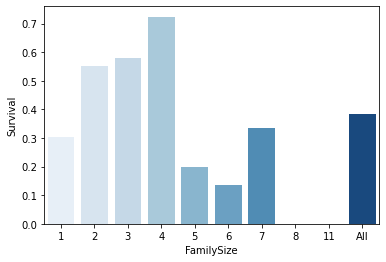

In [33]:
a = enc_fam_size(train)
b = pd.DataFrame(pd.crosstab(a['FamilySize'], a['Survived'], margins=True))
b['Survival'] = b[1]/b['All']
sns.barplot(x='FamilySize', y='Survival', data=b['Survival'].reset_index(),
           palette='Blues');
b

家庭人数和生存几率并不是线性关系。合理的做法是分箱：1， 2-4， 5+。把`enc_fam_size()`函数复写一遍。

In [34]:
def enc_fam_size(df:pd.DataFrame=train, bins:list=[0, 1, 4, 99], 
                 labels:list=['single', 'small', 'large'], 
                 inplace:bool=False) -> pd.DataFrame:
    assert len(bins) == len(labels)+1, 'bins should equal to labels+1'
    o = df if inplace else df.copy()
    x = 1 + o['SibSp'].astype('int') + o['Parch'].astype('int')
    o['FamilySize'] = pd.cut(x, bins=bins, labels=labels)
    if not inplace:
        return o

enc_fam_size(train)[['SibSp', 'Parch', 'FamilySize']].head()

,SibSp,Parch,FamilySize
0,1,0,small
1,1,0,small
2,0,0,single
3,1,0,small
4,0,0,single


#### (4) 年龄分箱

根据单因素分析，年龄与生存结局不是线性关系。所以分一下箱。

In [35]:
def enc_age_grp(df:pd.DataFrame=train, bins:list=[-99, 12, 18, 25, 40, 60, 99], 
                labels:list=['child', 'adol', 'young', 'adult', 'mid', 'eldly'], 
                inplace:bool=False) -> pd.DataFrame:
    assert len(bins) == len(labels)+1, 'bins should equal to labels+1'
    assert df['Age'].notna().all(), 'There are NAs in Age. Run imp_age() first.'
    o = df if inplace else df.copy()
    o['AgeGroup'] = pd.cut(o['Age'], bins=bins, labels=labels)
    if not inplace:
        return o

a = enc_age_grp(imp_age(imp_embark(enc_title(train))))
b = pd.crosstab(a['AgeGroup'], a['Survived'], margins=True)
b.assign(Survival=b[1]/b['All'])

Survived,0,1,All,Survival
AgeGroup,,,,
child,40,43,83,0.518072
adol,42,30,72,0.416667
young,116,73,189,0.386243
adult,241,128,369,0.346883
mid,93,63,156,0.403846
eldly,17,5,22,0.227273
All,549,342,891,0.383838


#### (5) 共用船票

部分乘客共用船票，提示这些乘客是结伴出行的。这也可能影响生存结局。

In [36]:
def enc_mates(df:pd.DataFrame=train, inplace:bool=False) -> pd.DataFrame:
    o = df if inplace else df.copy()
    dct = o.groupby('Ticket')['PassengerId'].count().to_dict()
    o['Mates'] = o['Ticket'].map(dct)-1
    if not inplace:
        return o

a = enc_mates(train)
b = pd.crosstab(a['Mates'], a['Survived'], margins=True)
b.assign(Survival=b[1]/b['All'])

Survived,0,1,All,Survival
Mates,,,,
0,384,163,547,0.297989
1,80,108,188,0.574468
2,19,44,63,0.698413
3,22,22,44,0.500000
4,10,0,10,0.000000
5,18,0,18,0.000000
6,16,5,21,0.238095
All,549,342,891,0.383838


In [37]:
a[['Mates', 'SibSp', 'Parch']].astype(int).corr()

,Mates,SibSp,Parch
Mates,1.000000,0.661622,0.593076
SibSp,0.661622,1.000000,0.414838
Parch,0.593076,0.414838,1.000000


`Mates`和`SibSp`、`Parch`还是有较高的相关性。还是分一下箱。复写一遍`enc_mates()`。

In [38]:
def enc_mates(df:pd.DataFrame=train, bins:list=[-1, 0, 3, 9], 
              labels:list=['none', 'few', 'many'],
              inplace:bool=False) -> pd.DataFrame:
    assert len(bins) == len(labels)+1, 'bins should equal to labels+1'
    o = df if inplace else df.copy()
    dct = o.groupby('Ticket')['PassengerId'].count().to_dict()
    o['Mates'] = o['Ticket'].map(dct)-1
    o['Mates'] = pd.cut(o['Mates'], bins=bins, labels=labels)
    if not inplace:
        return o
    
a = enc_mates(train)
b = pd.crosstab(a['Mates'], a['Survived'], margins=True)
b.assign(Survival=b[1]/b['All'])

Survived,0,1,All,Survival
Mates,,,,
none,384,163,547,0.297989
few,121,174,295,0.589831
many,44,5,49,0.102041
All,549,342,891,0.383838


### 4.3 异常值处理

没有看到特别异常的数据。略。

## 5. 模型拟合

暴力枚举。使用`sklearn`提供的各种分类器拟合模型，用网格搜索法优选（用`accuracy`指标）。

### 5.1 数据处理

将前面所有特征工程步骤整合起来，形成预处理函数。也可以建立pipeline，但本案例打算枚举模型，每次拟合都重复预处理一次没太大必要，直接对预处理结果拟合模型就行了。

In [88]:
def preproc_df(df:pd.DataFrame=train) -> pd.DataFrame:
    o = df.copy()
    o['Pclass'] = o['Pclass'].astype('category')
    # feature engineering, inplace
    imp_embark(o, inplace=True)
    enc_title(o, inplace=True)
    imp_age(o, inplace=True)
    imp_fare(o, inplace=True)
    enc_fam_size(o, inplace=True)
    enc_age_grp(o, inplace=True)
    enc_mates(o, inplace=True)
    # one-hot encoding
    a = pd.get_dummies(
        o[['Pclass', 'Title', 'AgeGroup', 'FamilySize', 'Mates', 'Embarked']],
        drop_first=True)
    # label encoding
    o['Sex'] = LabelEncoder().fit_transform(o['Sex'])
    # scale Fare (skewed)
    o['Fare'] = MinMaxScaler().fit_transform(o[['Fare']])
    # compose
    if 'Survived' in o.columns:
        o = pd.merge(o[['Survived', 'Fare', 'Sex']], a, 
                     left_index=True, right_index=True)
    else:
        o = pd.merge(o[['Fare', 'Sex']], a, 
                     left_index=True, right_index=True)
    return o

preproc_df(train).head()

,Survived,Fare,Sex,Pclass_2,Pclass_3,Title_Miss,Title_Mr,Title_Mrs,Title_Noble,AgeGroup_adol,AgeGroup_young,AgeGroup_adult,AgeGroup_mid,AgeGroup_eldly,FamilySize_small,FamilySize_large,Mates_few,Mates_many,Embarked_Q,Embarked_S
0,0,0.014151,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1
1,1,0.139136,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0
2,1,0.015469,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,1,0.103644,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1
4,0,0.015713,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1


In [40]:
train_data = preproc_df(train)
X_train = train_data.drop('Survived', axis=1)
y_train = train_data['Survived']

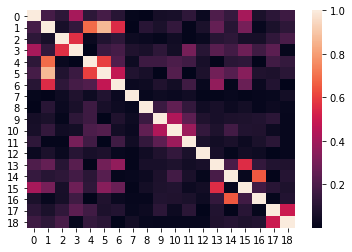

In [41]:
sns.heatmap(np.abs(X_train.corr().to_numpy()));

`Sex`和多个特征有共线性。构建模型时需要当心。

### 5.2 函数框架

构建一个通用函数，进行网格搜索拟合优化，并返回各项指标。

In [42]:
models = {}
params_grid = {}

In [43]:
def fit_model(clf, param_grid:dict, kfold:int=5, verbose=1,
              X:pd.DataFrame=X_train, y:pd.Series=y_train):
    searcher = GridSearchCV(
        clf, scoring='accuracy', param_grid=param_grid,
        cv=StratifiedKFold(n_splits=kfold), verbose=verbose)
    
    searcher.fit(X, y)
    model = searcher
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    fpr, tpr, thres = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    params = searcher.best_params_
    
    t0 = time.time()
    t_0 = time.process_time()
    model.fit(X, y)
    t1 = time.time()
    t_1 = time.process_time()
    
    return {'score': searcher.best_score_, 'accuracy': accuracy,
            'precision': precision, 'recall': recall, 'f1_score': f1, 'auc': auc_val,
            'params': params, 'cpu_time': t_1 - t_0, 'wall_time': t1 - t0,
            'model': model}

#### (1) Logistic Regression

Logistic回归是二分类问题最常用的模型。超参数包括`C`, `class_weight`, `penalty`, `solver`, `multi_class`等。

In [44]:
params_grid['Logistic'] = {
    'C': [0.1, 0.2, 0.5, 1], 'solver': ['newton-cg', 'lbfgs', 'sag'],
    'multi_class': ['ovr', 'multinomial']}
models['Logistic'] = fit_model(LogisticRegression(), params_grid['Logistic'])

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    3.1s finished


#### (2) Linear Discriminant Analysis

线性判别分析也是一种常用的分类器。超参数包括`solver`, `shrinkage`, `priors`等。

In [45]:
params_grid['LDA'] = {
    'solver': ['svd', 'lsqr', 'eigen']}
models['LDA'] = fit_model(LDA(), params_grid['LDA'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.2s finished


#### (3) Quadratic Discriminant Analysis

二次判别分析的分类能力比线性判别分析更强。超参数包括`priors`, `reg_param`, `tol`等。

In [46]:
params_grid['QDA'] = {}
models['QDA'] = fit_model(QDA(), params_grid['QDA'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/madlogos/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/madlogos/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/madlogos/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/madlogos/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/madlogos/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/madlogos/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
/Users/madlogos/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


#### (4) Ridge Classfier

岭回归是使用L2正则化的广义线性回归，用来减少过拟合。超参数包括`alpha`, `fit_intercept`, `normalize`, `solver`等。

In [47]:
params_grid['RidgeClf'] = {
    'alpha': [0.1, 1, 2, 5, 10]}
models['RidgeClf'] = fit_model(RidgeClassifier(), params_grid['RidgeClf'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished


#### (5) SVM Classifier

支持向量机可以作为非线性分类器。超参数包括`C`, `kernel`, `degree`, `gamma`, `coef0`等。

In [48]:
params_grid['SVC'] = {
    'C': [0.1, 0.2, 0.5, 1, 2], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
models['SVC'] = fit_model(SVC(), params_grid['SVC'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished


#### (6) Linear SVC

线性支持向量机，采用'linear'内核。超参数包括`penalty`, `loss`, `dual`, `multi_class`等。

In [49]:
params_grid['LinearSVC'] = {
    'C': [0.1, 0.2, 0.5, 1, 2], 'multi_class': ['ovr', 'crammer_singer']
}
models['LinearSVC'] = fit_model(LinearSVC(), params_grid['LinearSVC'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/madlogos/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/madlogos/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/madlogos/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/madlogos/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/madlogos/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increa

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/madlogos/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/madlogos/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/madlogos/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/madlogos/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/madlogos/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increa

#### (7) NuSVC

Nu-支持向量机，与SVC接近，只是增加了`nu`参数控制支持向量的数量。

In [50]:
params_grid['NuSVC'] = {
    'nu': [0.25, 0.5, 0.75],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
models['NuSVC'] = fit_model(NuSVC(), params_grid['NuSVC'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    2.0s finished


#### (8) Decision Tree

决策树是常用分类器，有较好的可解释性。超参数包括`splitter`, `criterion`, `max_depth`, `min_samples_split`等。

In [51]:
params_grid['DecisionTree'] = {
    'min_samples_split': [2, 3, 5, 7, 10], 'max_depth': [4, 6, 8],
    'min_samples_leaf': [1, 3, 5, 7, 10], 'max_features': ['sqrt', 'auto', 'log2']
}
models['DecisionTree'] = fit_model(DecisionTreeClassifier(), params_grid['DecisionTree'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=1)]: Done 1125 out of 1125 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=1)]: Done 1125 out of 1125 | elapsed:    7.4s finished


#### (9) Random Forest

从这里开始都是集成学习的方法。集成学习的效果一般会更好。随机森林是较常用的基于树的集成分类器。超参数包括`n_estimators`, `criterion`, `max_depth`, `min_samples_split`, `min_samples_leaf`等。

In [52]:
params_grid['RandomForest'] = {
    'min_samples_split': [2, 5, 10], 'max_depth': [4, 6, 8],
    'min_samples_leaf': [1, 5, 10], 'max_features': ['sqrt', 'auto', 'log2'],
    'n_estimators': [10, 50, 100], 'bootstrap': [True, False]
}
models['RandomForest'] = fit_model(RandomForestClassifier(), params_grid['RandomForest'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:  5.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:  5.0min finished


#### (10) Bagging

Bagging比随机森林稍弱一些。超参数包括`n_estimators`, `max_samples`, `max_features`等。

In [53]:
params_grid['Bagging'] = {
    'n_estimators': [10, 50, 100], 'bootstrap': [True, False]
}
models['Bagging'] = fit_model(BaggingClassifier(), params_grid['Bagging'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    6.1s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    5.7s finished


#### (11) AdaBoost

AdaBoost同样是集成分类器，但不同的树（弱分类器）权重不同。超参数包括`n_estimators`, `learning_rate`, `algorithm`等。

In [54]:
params_grid['AdaBoost'] = {
    'n_estimators': [10, 50, 100], 'learning_rate': [0.1, 0.5, 1, 2, 5]
}
models['AdaBoost'] = fit_model(AdaBoostClassifier(), params_grid['AdaBoost'])

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   11.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   11.2s finished


#### (12) Gradient Boosting

GBDT（梯度提升树）每次迭代会生成一颗新的决策树，在很多任务中表现很好。超参数包括`loss`, `learning_rate`, `n_estimators`, `subsample`等。

In [55]:
params_grid['GBDT'] = {
    'n_estimators': [10, 50, 100], 'learning_rate': [0.1, 0.2, 0.5, 1, 2],
    'subsample': [0.7, 0.85, 1], 'max_depth': [3, 6, 8]
}
models['GBDT'] = fit_model(GradientBoostingClassifier(), params_grid['GBDT'])

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 675 out of 675 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=1)]: Done 675 out of 675 | elapsed:  2.8min finished


#### (13) XGBoost

XGBoost是机器学习的耀眼明星，在分类任务中表现突出。超参数包括`learning_rate`, `n_estimators`, `max_depth`, `subsample`等。

In [56]:
params_grid['XGB'] = {
    'n_estimators': [10, 50, 100], 'learning_rate': [0.1, 0.2, 0.5, 1, 2],
    'subsample': [0.7, 0.85, 1], 'max_depth': [3, 6, 8]
}
models['XGB'] = fit_model(XGBClassifier(), params_grid['XGB'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=1)]: Done 675 out of 675 | elapsed:   42.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=1)]: Done 675 out of 675 | elapsed:   40.8s finished


### 5.3 模型比较

将上述模型的各方面指标拿出来比较一下。

In [58]:
model_prof = pd.DataFrame(models).T.drop('model', axis=1)
model_prof

,score,accuracy,precision,recall,f1_score,auc,params,cpu_time,wall_time
Logistic,0.820407,0.826038,0.782477,0.75731,0.769688,0.813081,"{'C': 1, 'multi_class': 'multinomial', 'solver...",6.04675,3.16264
LDA,0.82266,0.829405,0.795031,0.748538,0.771084,0.81416,{'solver': 'svd'},0.355296,0.201374
QDA,0.652012,0.631874,0.9375,0.0438596,0.0837989,0.521019,{},0.135013,0.0849531
RidgeClf,0.82266,0.829405,0.795031,0.748538,0.771084,0.81416,{'alpha': 0.1},0.465952,0.247024
SVC,0.828259,0.832772,0.804416,0.745614,0.7739,0.816341,"{'C': 0.2, 'kernel': 'rbf'}",2.87724,2.90562
LinearSVC,0.822654,0.829405,0.79321,0.751462,0.771772,0.814711,"{'C': 0.2, 'multi_class': 'ovr'}",9.28896,9.3367
NuSVC,0.828259,0.832772,0.806349,0.74269,0.773212,0.815789,"{'kernel': 'rbf', 'nu': 0.5}",1.97615,2.0194
DecisionTree,0.82605,0.833895,0.873077,0.663743,0.754153,0.801817,"{'max_depth': 8, 'max_features': 'auto', 'min_...",7.34198,7.39696
RandomForest,0.833859,0.819304,0.79868,0.707602,0.750388,0.798246,"{'bootstrap': True, 'max_depth': 4, 'max_featu...",300.751,302.055
Bagging,0.812579,0.942761,0.942249,0.906433,0.923994,0.935912,"{'bootstrap': True, 'n_estimators': 100}",6.0443,6.05026


In [62]:
def rank_model_prof(prof:str, df:pd.DataFrame=model_prof):
    assert prof in df.columns, 'prof should be one of the columns of df.'
    a = df.copy()[[prof]].sort_values(prof, ascending=False)
    sns.barplot(y=a.index, x=a[prof])
    plt.show();

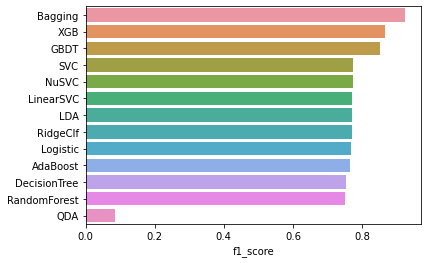

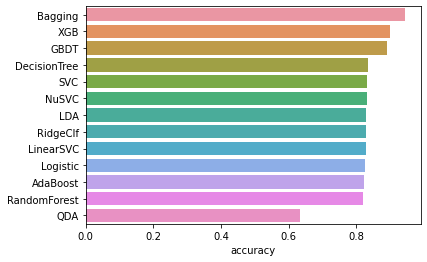

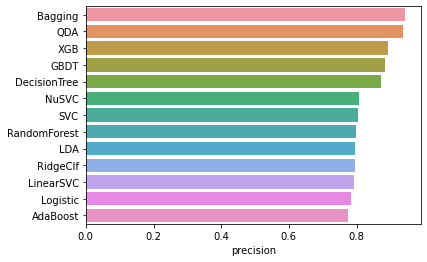

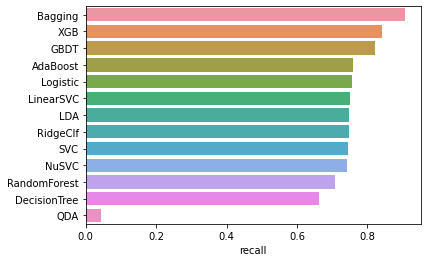

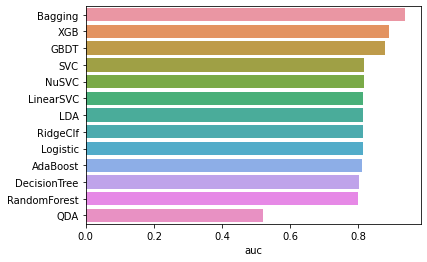

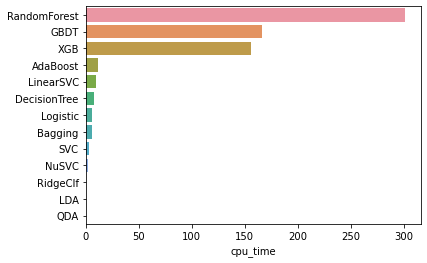

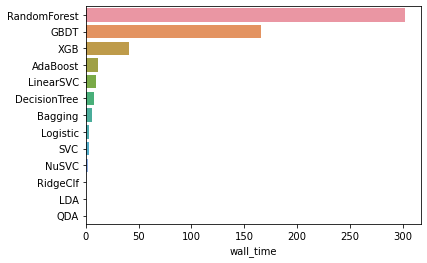

In [63]:
for var in ['f1_score', 'accuracy', 'precision', 'recall',
            'auc', 'cpu_time', 'wall_time']:
    rank_model_prof(var)

从上面的结果看，bagging的分类性能最好，且速度也较快。

## 6. 预测

将bagging模型用于test数据集，进行预测。

In [90]:
X_test = preproc_df(test)

In [91]:
y_pred = models['Bagging']['model'].predict(X_test)

In [92]:
y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [96]:
pd.DataFrame(
    {'PassengerId': test['PassengerId'], 'Survived': y_pred}).to_csv('pred.csv', index=False)